In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/world-economic-classifications/World Economic Classifications v2.csv


In [2]:
df = pd.read_csv('/kaggle/input/world-economic-classifications/World Economic Classifications v2.csv')

# World Economic Classifications Feature Engineering

<img src="https://www.mapsnworld.com/blog/wp-content/uploads/2012/01/world-map.jpg"  width="700" height="350">

I came across this interesting [World Economic Classifications](https://www.kaggle.com/datasets/jeanetteponder/world-economic-classifications) dataset and wanted to explore what features might correlate most with wealth rank. Some information about this dataset follows:

*This UN and IMF-sourced dataset was created as an easy-to-use and versatile source for many types of projects - social justice, economics, public policy, education, and more. When I posted my notebook about class inequality and university choice, I looked high and low for an economic classification dataset that I could merge with my base data, but couldn't find one - not even in the U.N. dataset collection. I made this to fill that need, and I hope it helps you out.

All data is sourced from the most recent info and numbers I could find from highly reputable sources. I'll definitely update it when new info comes available, so bookmark this and watch for updates.*

Thankyou to Jeanette Ponder for assembling this dataset. 

In addition to determining what features are most important in determining wealth rank, as a Canadian I wanted to know where Canada fits into these statistics, and what features would cause our wealth rank to increase or decrease. 

Some information about the dataset features follows:

The World Economic Classifications dataset is organized into nine columns:

1. country_name - Country name as commonly known. When applicable, any variations appear in parentheses after the most common name.
2. un_class_2014 - Classifications from the Development Policy and Analysis Division (DPAD) of the Department of Economic and Social Affairs of the United Nations Secretariat (UN/DESA), 2014. It describes basic economic conditions and is based on World Economic Situation and Prospects (WESP) data.
3. imf_class_2023 - Classifications from the International Monetary Fund (IMF)'s April 2023 report, "World Economic Outlook Database: Groups and Aggregates Information."
4. g7 - Denotes countries that are part of the United Nations Gang of 7, or G7, and are ranked as Major World Economies by the IMF.
5. eu_member - Member states of the European Union, both established and new.
6. fuel_exp_country - Fuel exporter country. According to DPAD, "An economy is classified as a fuel exporter if the share of fuel exports in its total merchandise exports is greater than 20 per cent and the level of fuel exports is at least 20 per cent higher than that of the country’s fuel imports. This criterion is drawn from the share of fuel exports in the total value of world merchandise trade."
7. wealth_rank - Wealth ranking according to gross domestic product (GDP) at Purchasing Power Parity, or PPP. Worldometer states, "PPP takes into account the relative cost of living, rather than using only exchange rates, therefore providing a more accurate picture of the real differences in income."
8. gdp_ppp_2022 - Per capita GDP at PPP as of 2022.
9. gdp_pc_2022 - Per capita GDP as of 2022.

# 1. Exploratory Data Analysis

I begin with some basic EDA (Exploratory Data Analysis) of the dataset.

Let's first look at the top 10 rows to get an idea of the wealthiest countries.

*Note: the dataset is sorted by wealth_rank when I read it into csv format, otherwise I would have sorted by wealth_rank column.*

In [3]:
df.head(10)

,country_name,un_class_2014,imf_class_2023,g7,eu_member,fuel_exp_country,wealth_rank,gdp_ppp_2022,gdp_pc_2022
0,Luxembourg,Developed,Advanced,No,Yes,No,1.0,"$142,214.00","$127,046.00"
1,Singapore,Developing,Advanced,No,No,No,2.0,"$127,565.00","$78,115.00"
2,Ireland,Developed,Advanced,No,Yes,No,3.0,"$126,905.00","$105,362.00"
3,Norway,Developed,Advanced,No,No,No,4.0,"$114,899.00","$106,594.00"
4,Qatar,Developing,Emerging,No,No,Yes,5.0,"$114,648.00","$88,046.00"
5,United Arab Emirates (UAE),Transition,Advanced,No,No,Yes,6.0,"$87,729.00","$53,758.00"
6,Switzerland,Developed,Advanced,No,No,No,7.0,"$83,598.00","$92,410.00"
7,United States,Developed,Advanced,Yes,No,No,8.0,"$76,399.00","$75,269.00"
8,Denmark,Developed,Advanced,No,Yes,No,9.0,"$74,005.00","$67,220.00"
9,Netherlands,Developed,Advanced,No,Yes,No,10.0,"$69,577.00","$56,429.00"


I'll gather some info about the datatypes of each column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country_name      205 non-null    object 
 1   un_class_2014     167 non-null    object 
 2   imf_class_2023    193 non-null    object 
 3   g7                205 non-null    object 
 4   eu_member         205 non-null    object 
 5   fuel_exp_country  205 non-null    object 
 6   wealth_rank       178 non-null    float64
 7   gdp_ppp_2022      175 non-null    object 
 8   gdp_pc_2022       176 non-null    object 
dtypes: float64(1), object(8)
memory usage: 14.5+ KB


Notice that the GDP columns (GDP Purchasing Power Parity and GDP Per Capita) are objects. This is because the data is read in dollar format. 

I'll remove the dollar signs and convert these columns to float to make the analysis easier.

In [5]:
columns_to_convert = ['gdp_ppp_2022', 'gdp_pc_2022']
df[columns_to_convert] = df[columns_to_convert].replace('[\$,]', '', regex=True).astype(float)

## 1.1 Features in Relation to GDP PC

First I want to perform some preliminary data visualization to grasp how the features in this dataset are represented in relation to GDP. From this point onward, I will create similar visualiations for the GDP Per Capita as well as the GDP Purchasing Power Parity as I think these are both important measures of a country's output. I will begin with GDP Per Capita. 

A definition of GDP PC follows:

*Gross domestic product per capita is a country's economic output per person. It's calculated by dividing the GDP of a country by its population. GDP per capita along with overall GDP is used by economists to analyze the economic prosperity of a country and to compare it to other countries.*

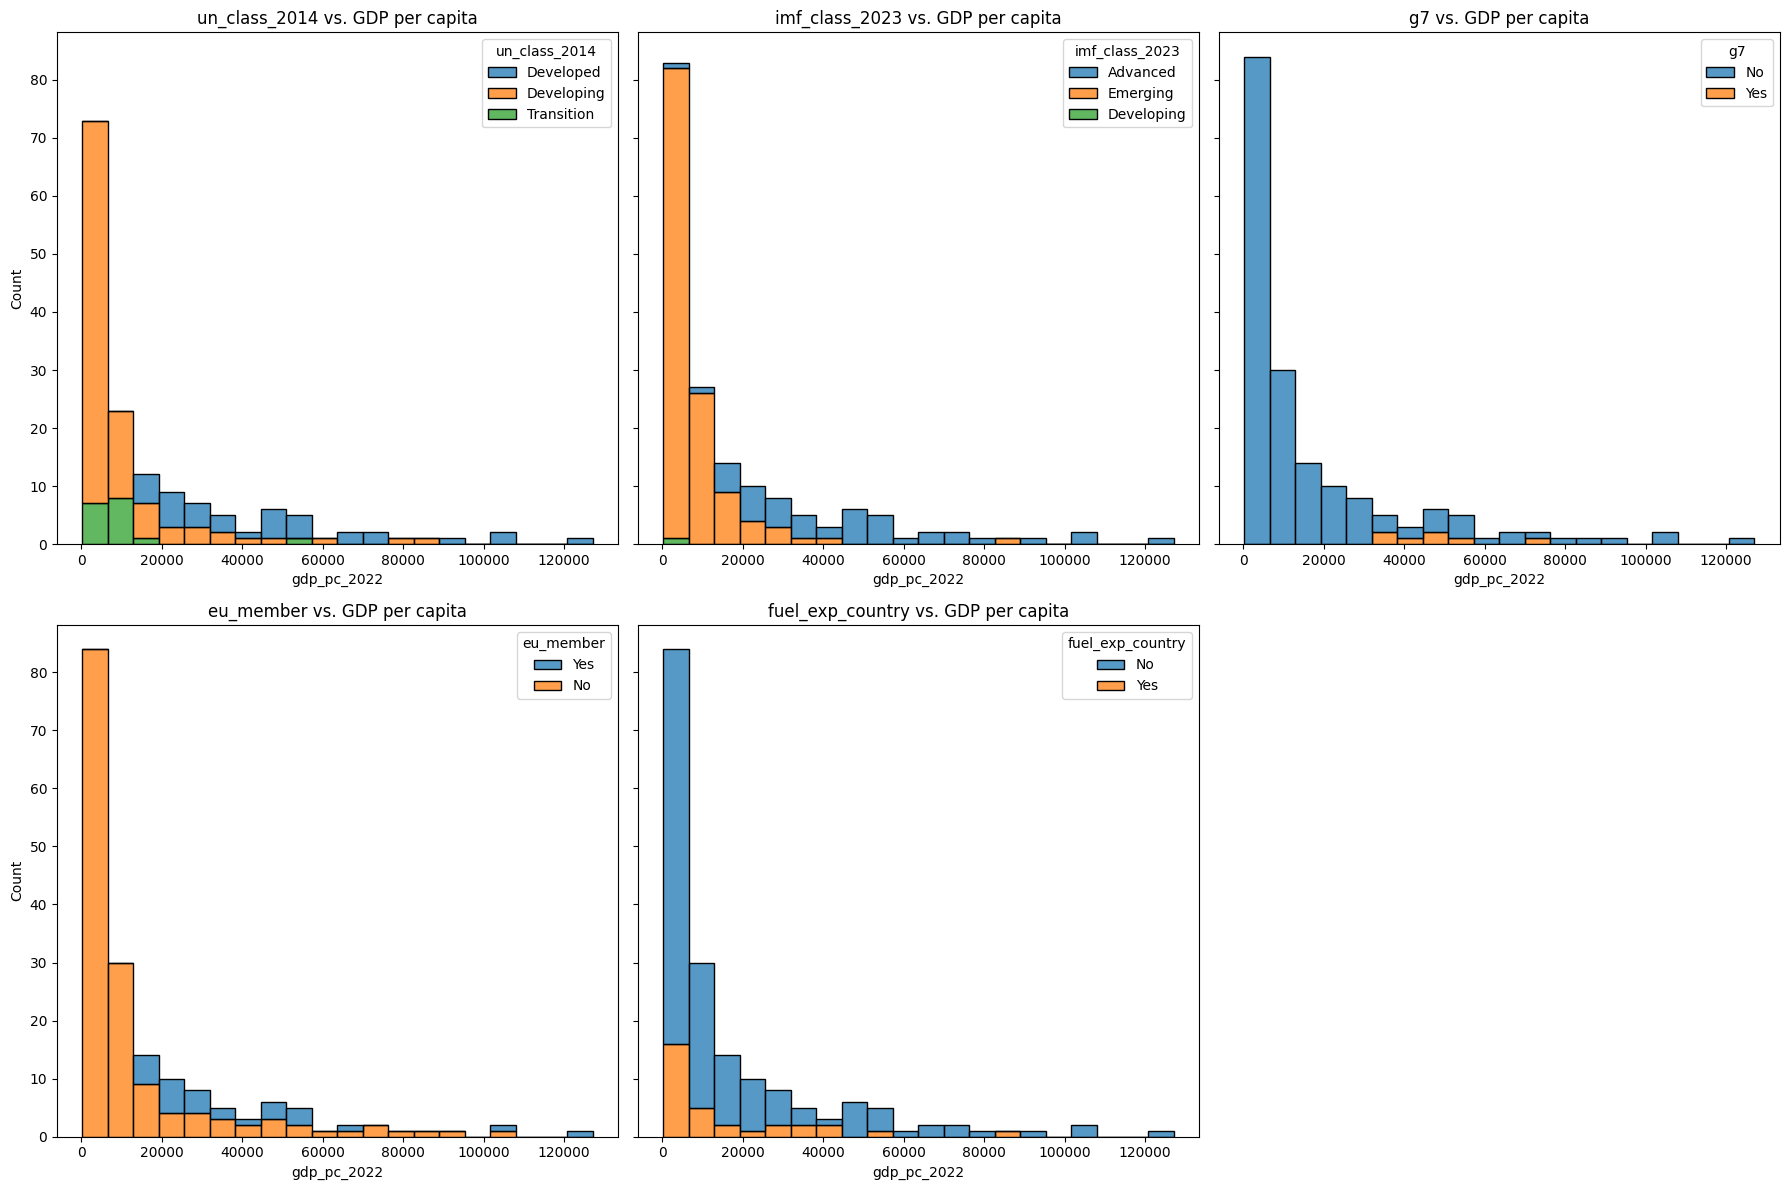

In [6]:
# Drop the 'wealth_rank' column
df_nowr = df.drop(columns=['wealth_rank'])

# Create a figure and axes with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array
axes = axes.flatten()

# Plot each histogram
histograms = ['un_class_2014', 'imf_class_2023', 'g7', 'eu_member', 'fuel_exp_country']
for i, histogram in enumerate(histograms):
    if i < 5:  # Plot only if not the 6th subplot
        sns.histplot(data=df_nowr, x='gdp_pc_2022', bins=20, hue=histogram, multiple='stack', ax=axes[i])
        axes[i].set_title(f'{histogram} vs. GDP per capita')

# Remove the 6th subplot
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

Observations:
* Developed countries economies are growing faster than developing or in-transition countries
* Technologically advanced countries have a higher GDP than emerging or developing countries
* Members of the G7 countries are somewhere between the lowest and highest GDP
* Being in the European Union moderately correlates with GDP
* Most Fuel exporting countries have a lower GDP, with the exception of Qatar and the United Arab Emirates

## 1.2 Features in Relation to GDP PPP

Now I plot the same charts in relation to GDP PPP (Purchasing Power Parity). 

A definition of GDP PPP follows:

*GDP per capita based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States.*
*

As mentioned in the data dictionary, "*PPP takes into account the relative cost of living, rather than using only exchange rates, therefore providing a more accurate picture of the real differences in income.*"

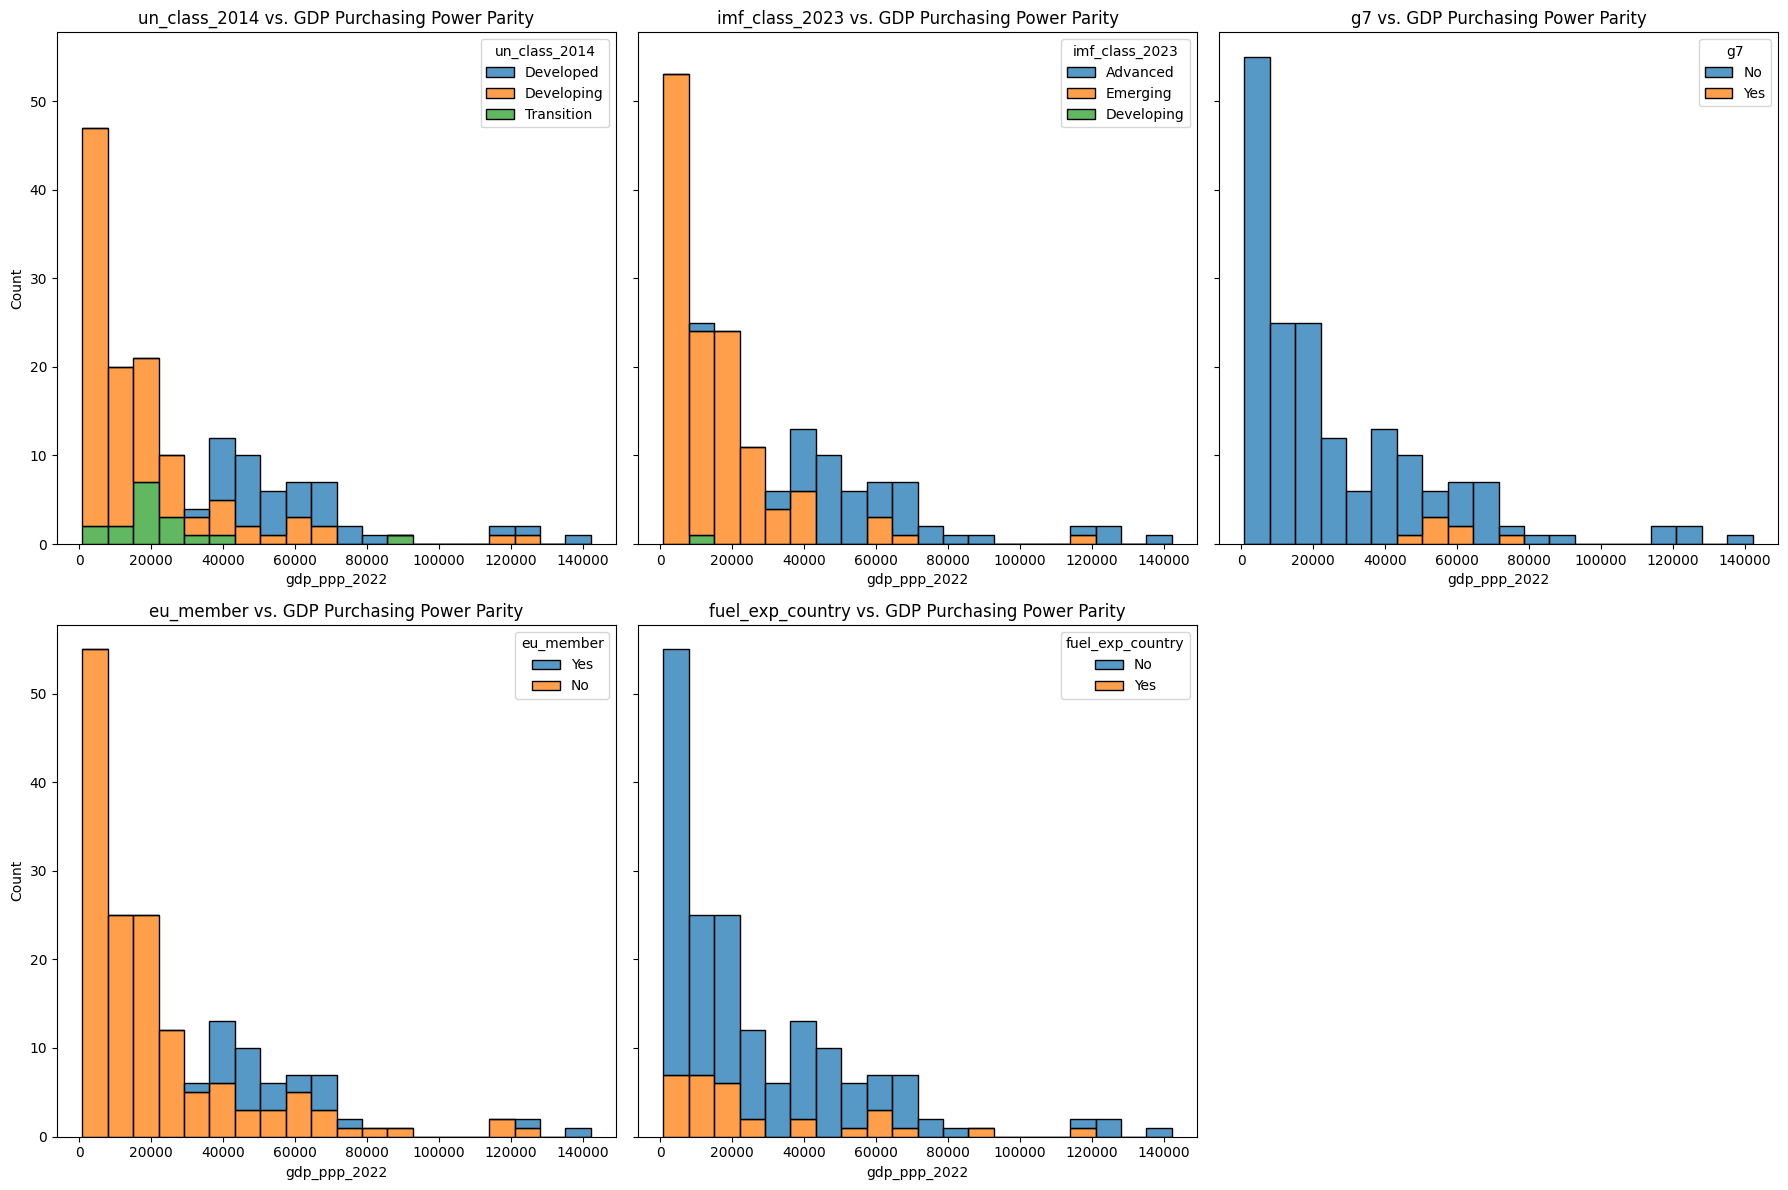

In [7]:
# Drop the 'wealth_rank' column
df_nowr = df.drop(columns=['wealth_rank'])

# Create a figure and axes with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array
axes = axes.flatten()

# Plot each histogram
histograms = ['un_class_2014', 'imf_class_2023', 'g7', 'eu_member', 'fuel_exp_country']
for i, histogram in enumerate(histograms):
    if i < 5:  # Plot only if not the 6th subplot
        sns.histplot(data=df_nowr, x='gdp_ppp_2022', bins=20, hue=histogram, multiple='stack', ax=axes[i])
        axes[i].set_title(f'{histogram} vs. GDP Purchasing Power Parity')

# Remove the 6th subplot
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

Observations:
* Countries in transition perhaps fare slightly better when factoring in purchasing power parity
* G7 countries are perhaps slightly more productive when factoring in PPP
* Being a member of the European Union appears to have little effect on GDP PPP
* There are a few more fuel exporting countries that appear to be more productive factoring in PPP

## 1.3 Top 10 countries by GDP PC

Which 10 countries have the highest GDP PC? And how does this GDP PC compare to their respective wealth rank? 

I can easily visualize this relationship with a bar plot after sorting the dataframe by GDP PC.

In [8]:
df10_gdp_pc = df.sort_values(by='gdp_pc_2022', ascending=False).head(10)
df10_gdp_pc

,country_name,un_class_2014,imf_class_2023,g7,eu_member,fuel_exp_country,wealth_rank,gdp_ppp_2022,gdp_pc_2022
0,Luxembourg,Developed,Advanced,No,Yes,No,1.0,142214.0,127046.0
3,Norway,Developed,Advanced,No,No,No,4.0,114899.0,106594.0
2,Ireland,Developed,Advanced,No,Yes,No,3.0,126905.0,105362.0
6,Switzerland,Developed,Advanced,No,No,No,7.0,83598.0,92410.0
4,Qatar,Developing,Emerging,No,No,Yes,5.0,114648.0,88046.0
1,Singapore,Developing,Advanced,No,No,No,2.0,127565.0,78115.0
7,United States,Developed,Advanced,Yes,No,No,8.0,76399.0,75269.0
11,Iceland,Developed,Advanced,No,No,No,12.0,69081.0,74663.0
8,Denmark,Developed,Advanced,No,Yes,No,9.0,74005.0,67220.0
17,Australia,Developed,Advanced,No,No,No,18.0,62625.0,64003.0


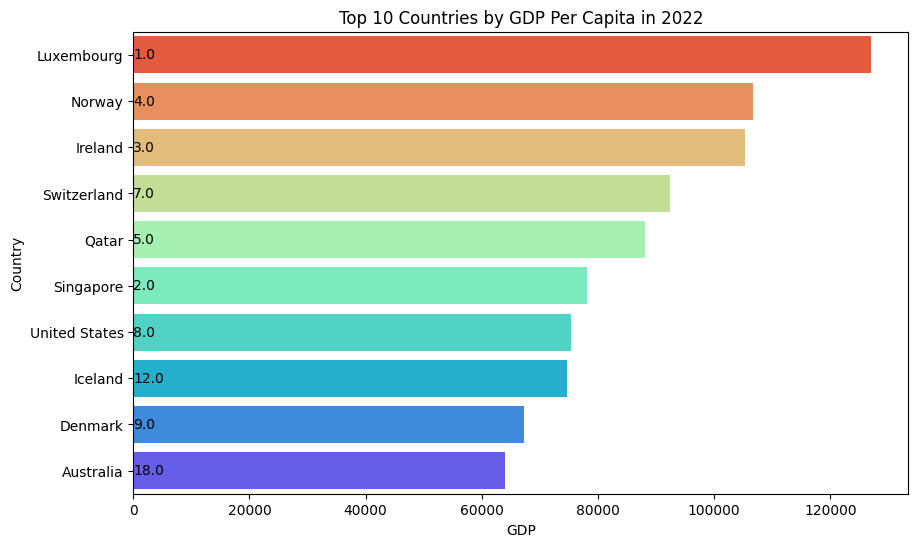

In [9]:
# Plot the top 10 most wealthy countries by GDP per capita
plt.figure(figsize=(10, 6))
sns.barplot(df10_gdp_pc, y='country_name', x='gdp_pc_2022', palette='rainbow_r')

# Annotate bars with values from 'wealth_rank' column
for index, value in enumerate(df10_gdp_pc['wealth_rank']):
    plt.text(value, index, str(value), ha='left', va='center')
    
# Set labels and title
plt.xlabel('GDP')
plt.ylabel('Country')
plt.title('Top 10 Countries by GDP Per Capita in 2022')

plt.show()

There is some interesting insight from this chart. For example, Australia has the 10th highest GDP PC in the world, but is the 18th country by Wealth Rank. It is clear that GDP PC is not the most important factor influencing wealth rank. 

Where does Canada fit into all of this? In order to visualize this I'll isolate the row for Canada from the dataframe, examine it's GDP PC, and then add it to the bar chart above.

In [10]:
canada_data = df[df['country_name'] == 'Canada']
canada_data

,country_name,un_class_2014,imf_class_2023,g7,eu_member,fuel_exp_country,wealth_rank,gdp_ppp_2022,gdp_pc_2022
21,Canada,Developed,Advanced,Yes,No,No,22.0,58400.0,55646.0


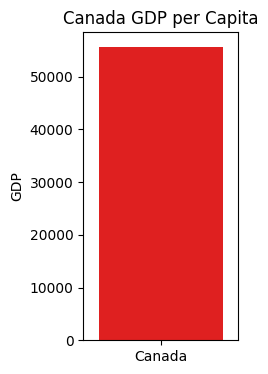

In [44]:
plt.figure(figsize=(2, 4))
sns.barplot(canada_data, x='country_name', y='gdp_pc_2022', color='red')

# Set labels and title
plt.xlabel('')
plt.ylabel('GDP')
plt.title('Canada GDP per Capita')

plt.show()

Canada's GPD Per Capita is 55,646.

In [12]:
df11_gdp_pc = pd.concat([df10_gdp_pc, canada_data])

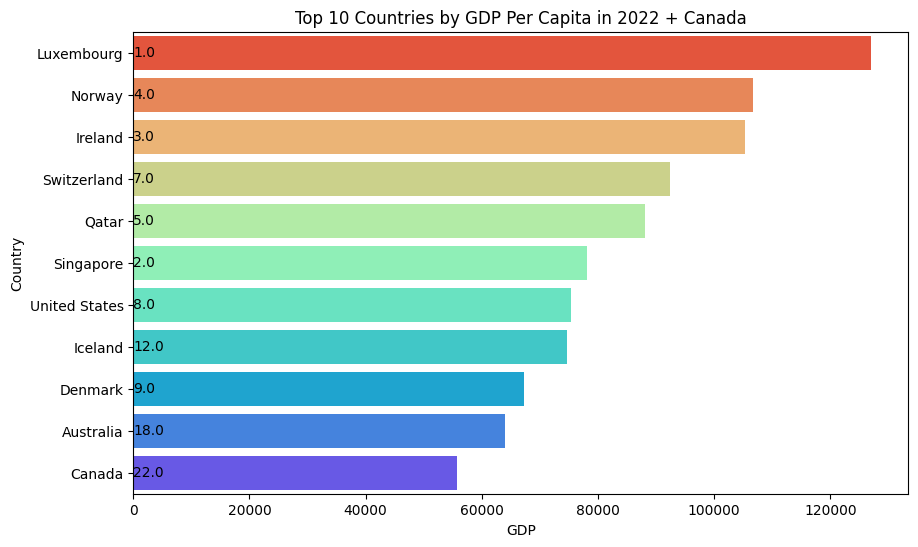

In [43]:
# Plot the top 10 most wealthy countries by GDP per capita
plt.figure(figsize=(10, 6))
sns.barplot(df11_gdp_pc, y='country_name', x='gdp_pc_2022', palette='rainbow_r')

# Annotate bars with values from 'wealth_rank' column
for index, value in enumerate(df11_gdp_pc['wealth_rank']):
    plt.text(value, index, str(value), ha='left', va='center')

# Set labels and title
plt.xlabel('GDP')
plt.ylabel('Country')
plt.title('Top 10 Countries by GDP Per Capita in 2022 + Canada')

plt.show()

Canada's wealth rank is 22. We have a competitive GDP, but it is still well below the top 10 in the world.

## 1.4 Top 10 countries by GDP PPP

I'll now turn my attention to GDP PPP. I will sort again, this time by gdp_ppp_2022 and visualize the results. I will then add Canada to the visualization for my own knowledge and interest.

In [14]:
df10_gdp_ppp = df.sort_values(by='gdp_ppp_2022', ascending=False).head(10)
df10_gdp_ppp

,country_name,un_class_2014,imf_class_2023,g7,eu_member,fuel_exp_country,wealth_rank,gdp_ppp_2022,gdp_pc_2022
0,Luxembourg,Developed,Advanced,No,Yes,No,1.0,142214.0,127046.0
1,Singapore,Developing,Advanced,No,No,No,2.0,127565.0,78115.0
2,Ireland,Developed,Advanced,No,Yes,No,3.0,126905.0,105362.0
3,Norway,Developed,Advanced,No,No,No,4.0,114899.0,106594.0
4,Qatar,Developing,Emerging,No,No,Yes,5.0,114648.0,88046.0
5,United Arab Emirates (UAE),Transition,Advanced,No,No,Yes,6.0,87729.0,53758.0
6,Switzerland,Developed,Advanced,No,No,No,7.0,83598.0,92410.0
7,United States,Developed,Advanced,Yes,No,No,8.0,76399.0,75269.0
8,Denmark,Developed,Advanced,No,Yes,No,9.0,74005.0,67220.0
9,Netherlands,Developed,Advanced,No,Yes,No,10.0,69577.0,56429.0


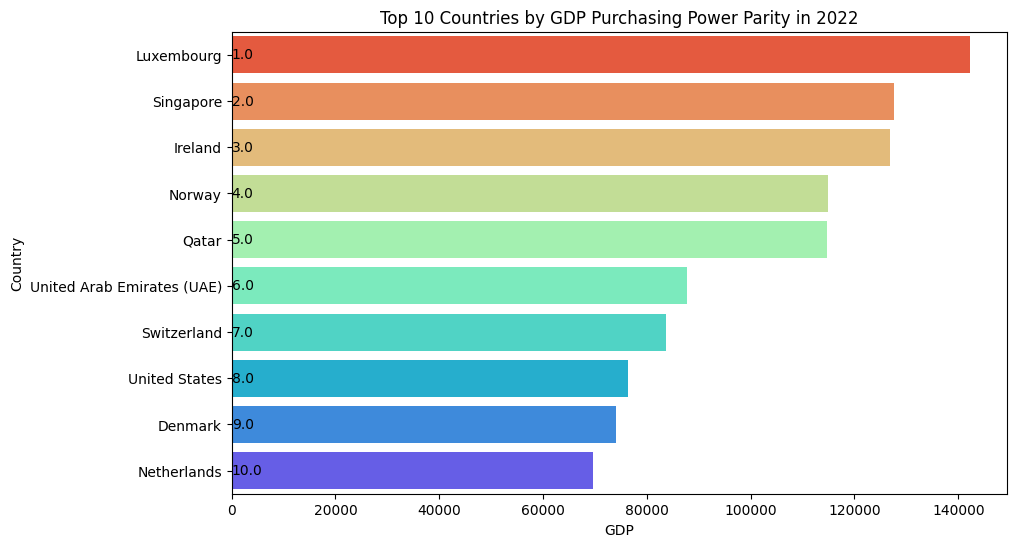

In [45]:
# Plot the top 10 most wealthy countries by GDP Purchasing Power Parity
plt.figure(figsize=(10, 6))
sns.barplot(df10_gdp_ppp, y='country_name', x='gdp_ppp_2022', palette='rainbow_r')

# Annotate bars with values from 'wealth_rank' column
for index, value in enumerate(df10_gdp_ppp['wealth_rank']):
    plt.text(value, index, str(value), ha='left', va='center')

# Set labels and title
plt.xlabel('GDP')
plt.ylabel('Country')
plt.title('Top 10 Countries by GDP Purchasing Power Parity in 2022')

plt.show()

Now we can observe something that you probably assumed when reading the summary of features in this dataset: wealth rank is directly correlated to a country's GDP Purchasing Power Parity. The top 10 countries by wealth rank perfectly align with the top 10 countries by GDP PPP. Where does Canada fit into this? Well, we can assume that they would have the 22nd highest GDP PPP in the world.

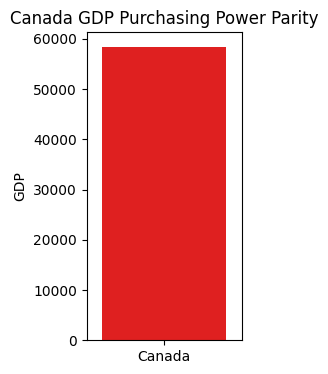

In [16]:
# Plot the top 10 most wealthy countries by GDP per capita
plt.figure(figsize=(2, 4))
sns.barplot(canada_data, x='country_name', y='gdp_ppp_2022', color='red')

# Set labels and title
plt.xlabel('')
plt.ylabel('GDP')
plt.title('Canada GDP Purchasing Power Parity')

plt.show()

Canada's GDP PPP is 58,400. Sorting by GDP PPP, I see that this is the 22nd row. As expected, Canada's wealth rank and position when sorting the dataset by GDP PPP are both 22.

In [17]:
df11_gdp_ppp = pd.concat([df10_gdp_ppp, canada_data])

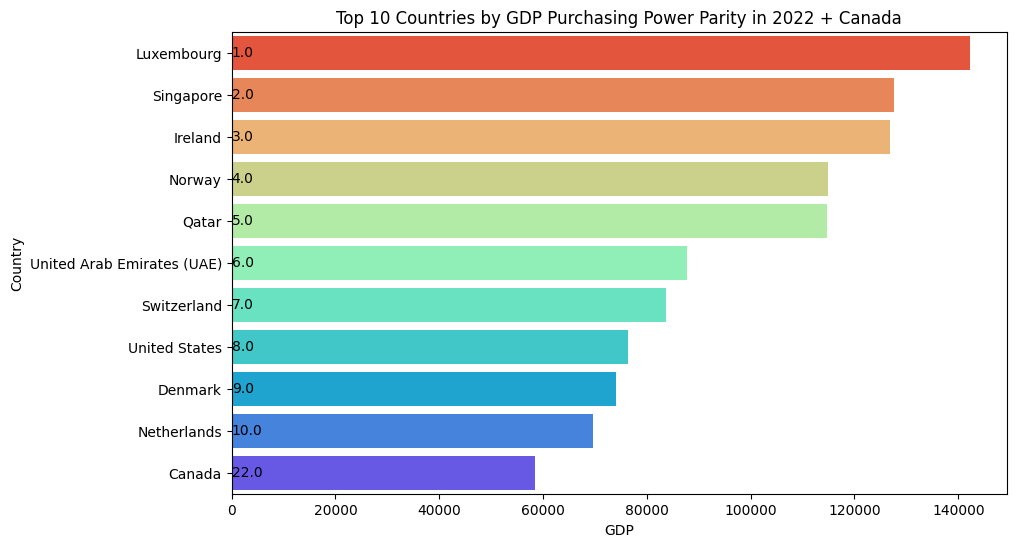

In [46]:
# Plot the top 10 most wealthy countries by GDP Purchasing Power Parity
plt.figure(figsize=(10, 6))
sns.barplot(df11_gdp_ppp, y='country_name', x='gdp_ppp_2022', palette='rainbow_r')

# Annotate bars with values from 'wealth_rank' column
for index, value in enumerate(df11_gdp_ppp['wealth_rank']):
    plt.text(value, index, str(value), ha='left', va='center')

# Set labels and title
plt.xlabel('GDP')
plt.ylabel('Country')
plt.title('Top 10 Countries by GDP Purchasing Power Parity in 2022 + Canada')

plt.show()

This is the end of my EDA. I have confirmed that wealth rank is a direct function of GDP Purchasing Power Parity. I also know that Canada has the 22nd highest GDP PPP in the world, and is thus considered the 22nd wealthiest country in terms of wealth rank. 

For the rest of this notebook, I will turn my attention to the other features that could affect wealth rank. We have confirmed that GDP PPP is the number one contributor to a country's estimated wealth rank, but how might these other features affect a country's GDP PPP? Is there any correlation at all? I will investigate this in feature engineering.

# 2. Feature Engineering

## 2.1 Relationship of Features to GDP PPP/Wealth Rank

I'll start by creating strip plots for each feature in relation to GDP PPP.

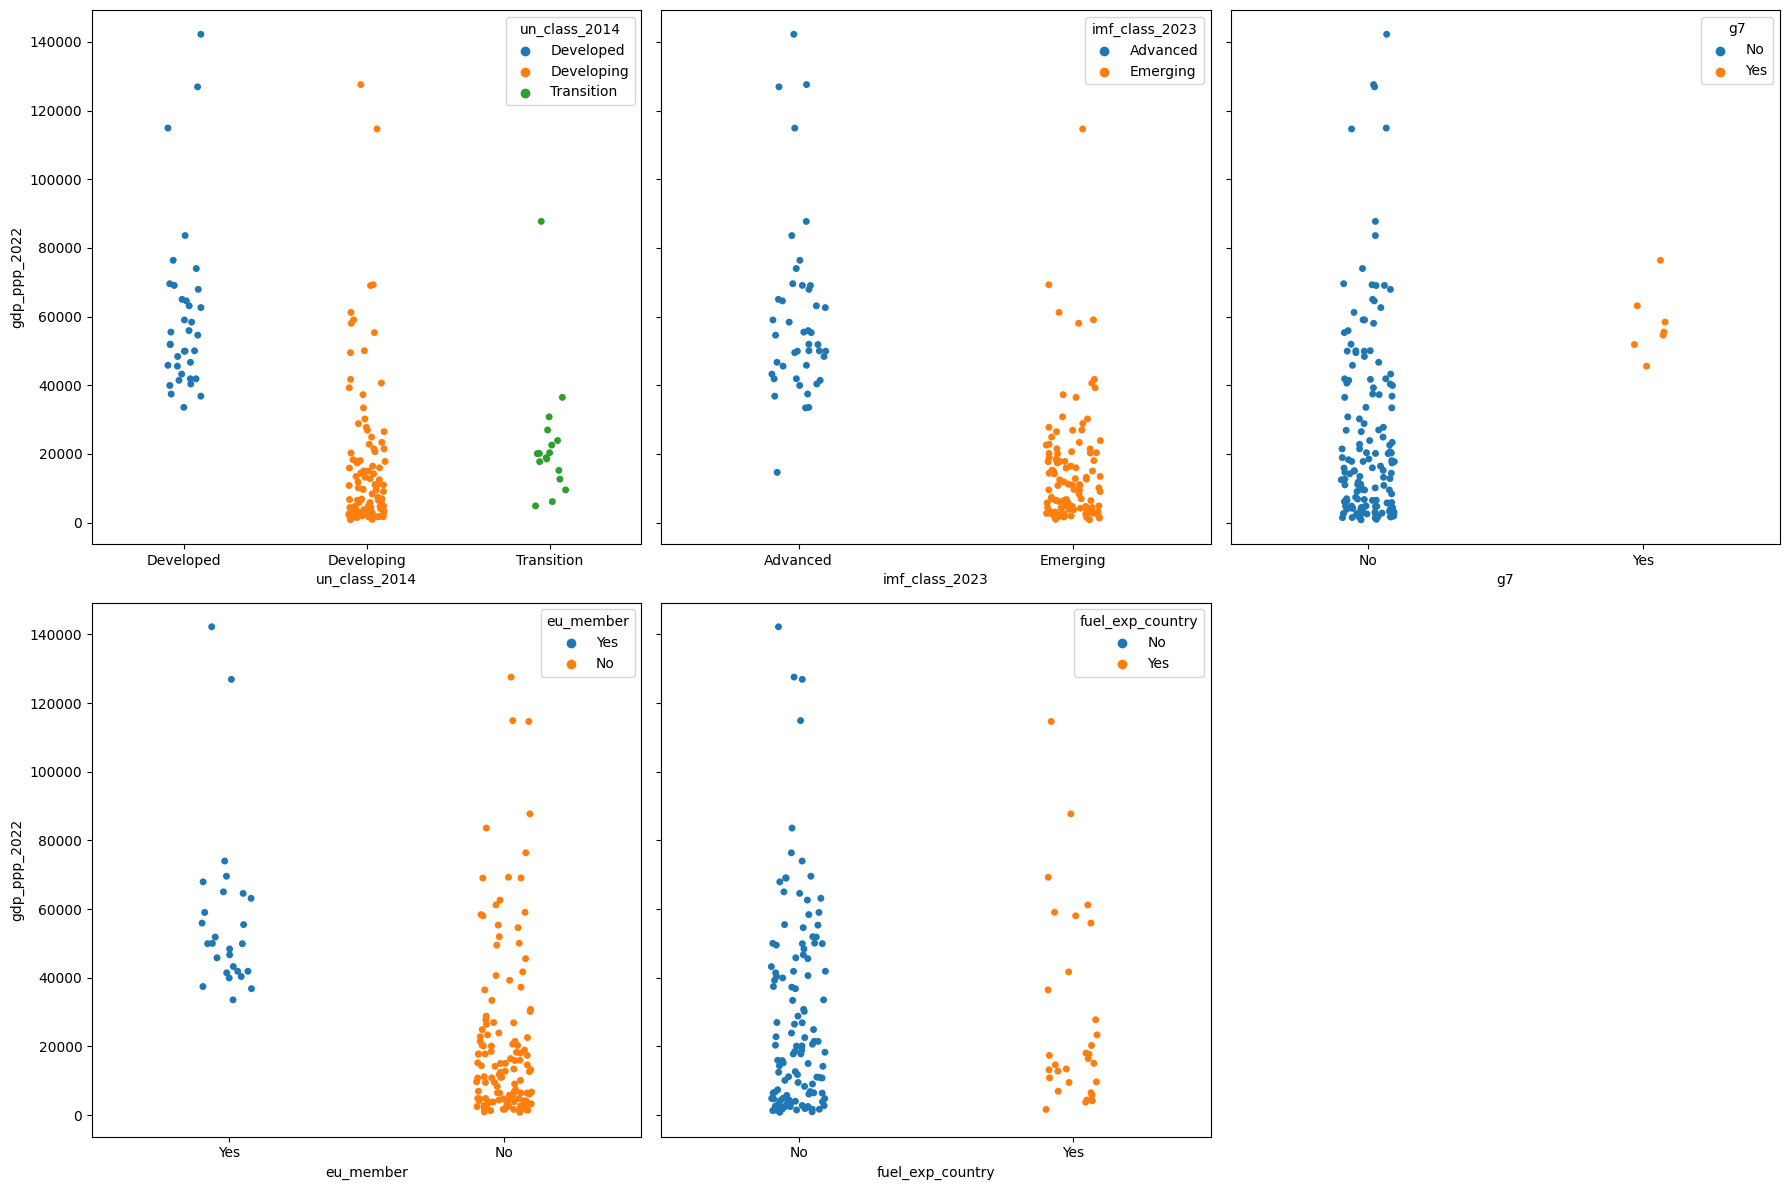

In [20]:
df2 = df.copy().dropna()

# Create a figure and axes with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

# Flatten the axes array
axes = axes.flatten()

# Plot each strip plot on separate subplots
sns.stripplot(x='un_class_2014', y='gdp_ppp_2022', hue='un_class_2014', data=df2, ax=axes[0])
sns.stripplot(x='imf_class_2023', y='gdp_ppp_2022', hue='imf_class_2023', data=df2, ax=axes[1])
sns.stripplot(x='g7', y='gdp_ppp_2022', hue='g7', data=df2, ax=axes[2])
sns.stripplot(x='eu_member', y='gdp_ppp_2022', hue='eu_member', data=df2, ax=axes[3])
sns.stripplot(x='fuel_exp_country', y='gdp_ppp_2022', hue='fuel_exp_country', data=df2, ax=axes[4])

# Hide the empty subplot in the last cell
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

I can deduct some more information from these strip plots than I could from the histograms we explored earlier. I will list some of these observations below:
* Developed countries have the highest GDP PPP, followed by Developing countries and Transitioning countries
* Advanced countries have higher GDP PPP than emerging countries
* Being in the G7 does not have an effect on GDP PPP (or wealth rank)
* Countries in the European Union generally have a higher GDP PPP than countries not in the European Union
* The production of fuel does not appear to influence GDP/Wealth Rank as much as other features

## 2.2 PreProcessing

In [21]:
palette = ['#008080','#FF6347', '#E50000', '#D2691E']

I'll start by dropping country name, which is not useful in terms of feature engineering.

In [22]:
df = df.drop('country_name', axis=1)

In [23]:
# print('Number of duplicated values in training dataset: ', df.duplicated().sum())

Number of duplicated values in training dataset:  19


In [24]:
# df.drop_duplicates(inplace=True)
# print("Duplicated values dropped succesfully")
# print("*" * 100)

Duplicated values dropped succesfully
****************************************************************************************************


I separate columns in the dataset into categoric and numeric features before scaling.

In [25]:
# distinction is based on the number of different values in the column
columns = list(df.columns)

categoric_columns = []
numeric_columns = []

for i in columns:
    if len(df[i].unique()) > 6:
        numeric_columns.append(i)
    else:
        categoric_columns.append(i)
        
numeric_columns = numeric_columns[1:] # Excluding target:'Churn'

Printing the numeric and categoric columns to review in case I have made an error.

In [26]:
print('Numerical features: ',numeric_columns)
print('Categorical features: ',categoric_columns)

Numerical features:  ['gdp_ppp_2022', 'gdp_pc_2022']
Categorical features:  ['un_class_2014', 'imf_class_2023', 'g7', 'eu_member', 'fuel_exp_country']


This looks reasonable to me. The categorical features appear binary, and the numerical features (GDP) contain many values.

I want to drop NAs from my dataset before going any further into encoding.

In [27]:
df.dropna(inplace=True)

## 2.3 Splitting Dataset into Train/Test Sets

I split my dataset into training and testing sets. I am preparing the dataset for modeling at this point, although I am not 100% sure that I want to create a machine learning model that would predict wealth rank of countries. At this point I'm mostly interested in what features might contribute to this variable (aside from GDP PPP 2022 which we have confirmed is directly related.)

I will assume 'wealth_rank' as the target variable that I would predict.

In [29]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df.drop('wealth_rank', axis=1)  # Features
y = df['wealth_rank']  # Target variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 2.4 Scaling the Data

I use StandardScaler to scale my data.

In [30]:
from sklearn.preprocessing import StandardScaler
Standard_Scaler = StandardScaler()
Standard_Scaler.fit_transform(X_train[numeric_columns])
Standard_Scaler.transform(X_test[numeric_columns])

array([[-0.43546881, -0.54028057],
       [-0.45023841, -0.52115095],
       [-0.57331841, -0.54377279],
       [-0.74674319, -0.62219259],
       [ 0.74404223,  0.54009673],
       [-0.73753748, -0.64295191],
       [-0.34533379, -0.41203839],
       [-0.40559241, -0.46818557],
       [ 1.1202961 ,  0.46303502],
       [ 1.23325993,  1.44826865],
       [ 1.04735855,  0.47405492],
       [ 1.3840245 ,  1.1575217 ],
       [ 1.40182895,  1.48264764],
       [ 0.45343855,  0.24488751],
       [ 0.18805784, -0.19749951],
       [-0.26025685, -0.44967679],
       [-0.71703538, -0.58897767],
       [-0.85350244, -0.66953161],
       [-0.21894917, -0.27657895],
       [-0.5701824 , -0.50799691],
       [-0.3348467 , -0.53667194],
       [-0.79570542, -0.64531886],
       [ 0.73986088,  0.36878381],
       [-0.22016311, -0.21810362],
       [ 0.02822244,  0.09996026],
       [ 0.74276084,  0.43009172],
       [ 0.89689747,  1.05799336],
       [-0.83687821, -0.6474918 ],
       [-0.85346872,

Confirming once more the Categoric Columns.

In [31]:
print(categoric_columns)

['un_class_2014', 'imf_class_2023', 'g7', 'eu_member', 'fuel_exp_country']


## 2.5 OneHotEncoding the Data

At this point I use OneHotEncoder to encode my categorical data and prepare it for further analysis.

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
# Encoding multiple columns. Unfortunately you cannot pass a list here so you need to copy-paste all printed categorical columns.
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), 
     ['un_class_2014', 'imf_class_2023', 'g7', 'eu_member', 'fuel_exp_country']))

After transforming the data I'll look at the top 5 rows of X_train and X_test to validate that encoding was performed successfully.

In [33]:
# Transforming
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_train.index
# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)
# Dropping old categorical columns
X_train.drop(categoric_columns, axis=1, inplace=True)
# CHecking result
X_train.head()

,gdp_ppp_2022,gdp_pc_2022,onehotencoder__un_class_2014_Developed,onehotencoder__un_class_2014_Developing,onehotencoder__un_class_2014_Transition,onehotencoder__imf_class_2023_Advanced,onehotencoder__imf_class_2023_Emerging,onehotencoder__g7_No,onehotencoder__g7_Yes,onehotencoder__eu_member_No,onehotencoder__eu_member_Yes,onehotencoder__fuel_exp_country_No,onehotencoder__fuel_exp_country_Yes
105,11822.0,6047.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
73,20377.0,7585.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
22,58056.0,43233.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
46,39956.0,22238.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
81,17837.0,20019.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [34]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_test.index
# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)
# Dropping old categorical columns
X_test.drop(categoric_columns, axis=1, inplace=True)
# CHecking result
X_test.head()

,gdp_ppp_2022,gdp_pc_2022,onehotencoder__un_class_2014_Developed,onehotencoder__un_class_2014_Developing,onehotencoder__un_class_2014_Transition,onehotencoder__imf_class_2023_Advanced,onehotencoder__imf_class_2023_Emerging,onehotencoder__g7_No,onehotencoder__g7_Yes,onehotencoder__eu_member_No,onehotencoder__eu_member_Yes,onehotencoder__fuel_exp_country_No,onehotencoder__fuel_exp_country_Yes
93,15091.0,4295.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
95,14653.0,4788.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
109,11003.0,4205.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
132,5860.0,2184.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
29,50070.0,32138.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


These are the resulting columns after OneHotEncoding has been performed.

In [35]:
print(X_train.columns)

Index(['gdp_ppp_2022', 'gdp_pc_2022', 'onehotencoder__un_class_2014_Developed',
       'onehotencoder__un_class_2014_Developing',
       'onehotencoder__un_class_2014_Transition',
       'onehotencoder__imf_class_2023_Advanced',
       'onehotencoder__imf_class_2023_Emerging', 'onehotencoder__g7_No',
       'onehotencoder__g7_Yes', 'onehotencoder__eu_member_No',
       'onehotencoder__eu_member_Yes', 'onehotencoder__fuel_exp_country_No',
       'onehotencoder__fuel_exp_country_Yes'],
      dtype='object')


I want to edit these feature names to remove the "onehotencoder" prefix for clarity before I proceed. 

Once again I display the top 5 rows to validate that the process is being applied correctly.

In [36]:
# Setting new feature names

X_train.columns = ['gdp_ppp_2022', 'gdp_pc_2022', 
    'un_class_2014_Developed', 'un_class_2014_Developing', 'un_class_2014_Transition', 
    'imf_class_2023_Advanced', 'imf_class_2023_Emerging', 
    'g7_No', 'g7_Yes', 
    'eu_member_No', 'eu_member_Yes', 
    'fuel_exp_country_No', 'fuel_exp_country_Yes']

X_test.columns = ['gdp_ppp_2022', 'gdp_pc_2022', 
    'un_class_2014_Developed', 'un_class_2014_Developing', 'un_class_2014_Transition', 
    'imf_class_2023_Advanced', 'imf_class_2023_Emerging', 
    'g7_No', 'g7_Yes', 
    'eu_member_No', 'eu_member_Yes', 
    'fuel_exp_country_No', 'fuel_exp_country_Yes']
# After renaming the columns

X_train.head()

,gdp_ppp_2022,gdp_pc_2022,un_class_2014_Developed,un_class_2014_Developing,un_class_2014_Transition,imf_class_2023_Advanced,imf_class_2023_Emerging,g7_No,g7_Yes,eu_member_No,eu_member_Yes,fuel_exp_country_No,fuel_exp_country_Yes
105,11822.0,6047.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
73,20377.0,7585.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
22,58056.0,43233.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
46,39956.0,22238.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
81,17837.0,20019.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


# 3. Building a Model

I have decided I want to use machine learning to determine the features of most important. I have a hunch of what they will be (I suspect un class, imf class, and eu membership will be correlated to wealth rank) but I will let my model do the heavy lifting.  

## 3.1 Model Selection

I employ a RandomForestClassifier model to determine feature importance. This can be a useful good model for simple classification tasks.

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

## 3.2 Visualizing Feature Imporance

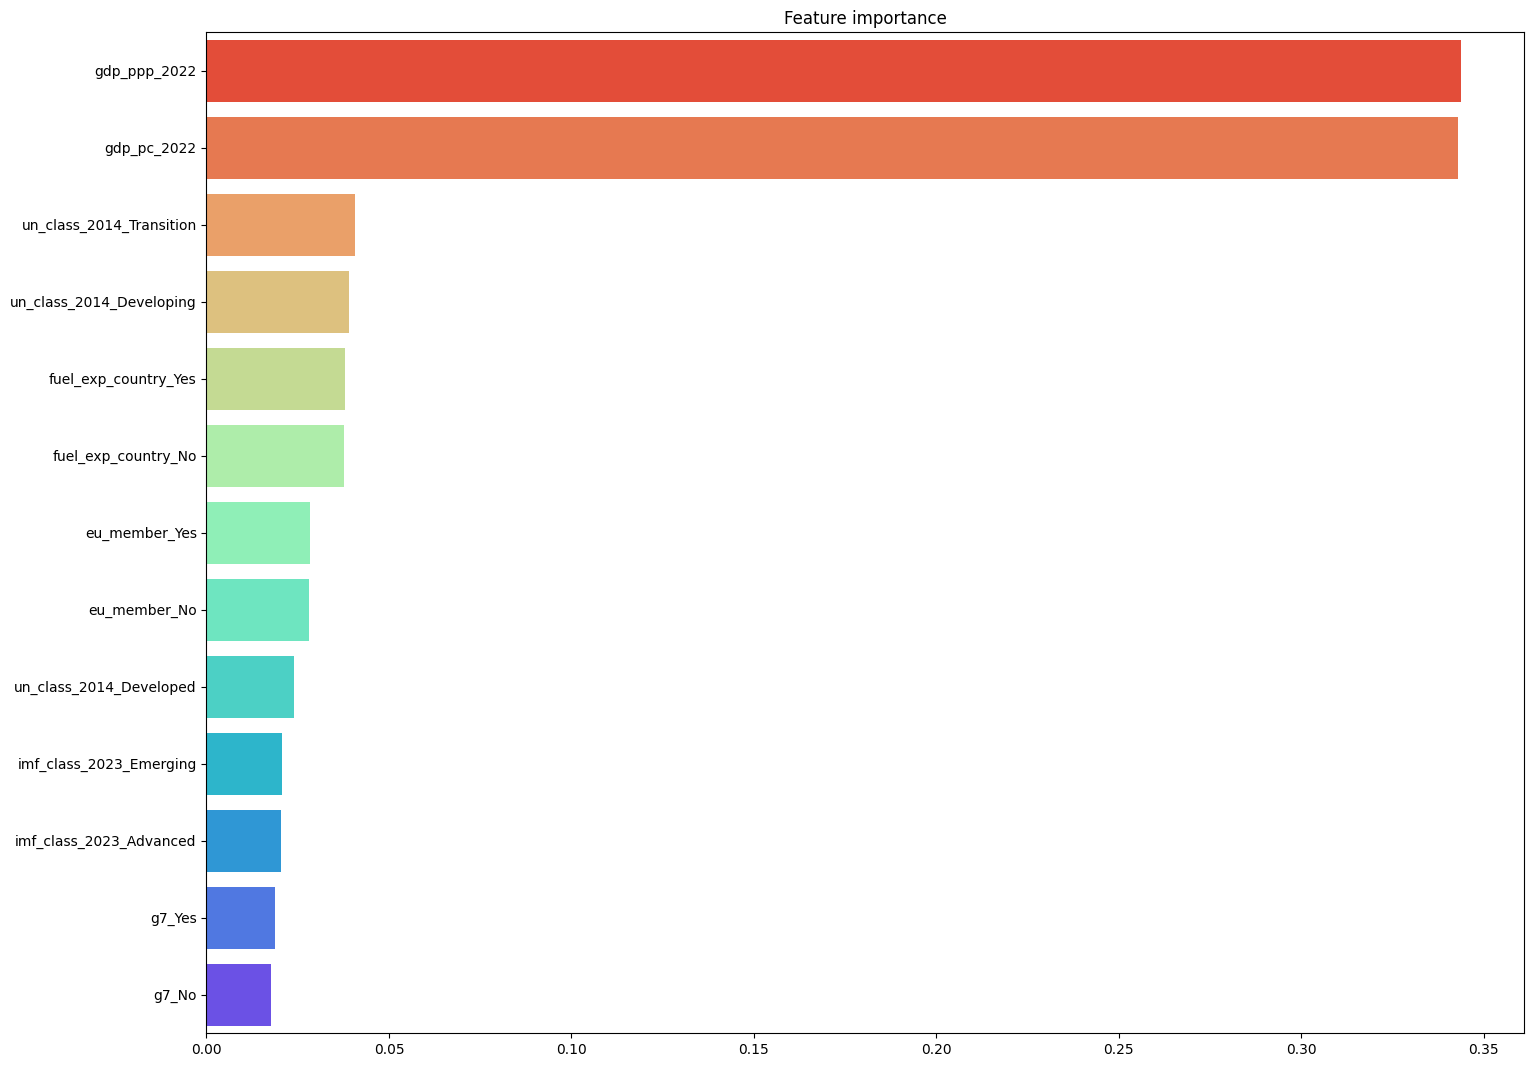

In [49]:
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette='rainbow_r', orient='h')

As we have established multiple times, GDP PPP is directly correlated to wealth_rank. I also think that GDP PC is extremely correlated with wealth rank, as we can see above. I want to remove these 2 outliers to determine what *other* features are correlated with wealth rank, and to what degree.

I drop GDP PPP and GDP PC from the feature importance series.

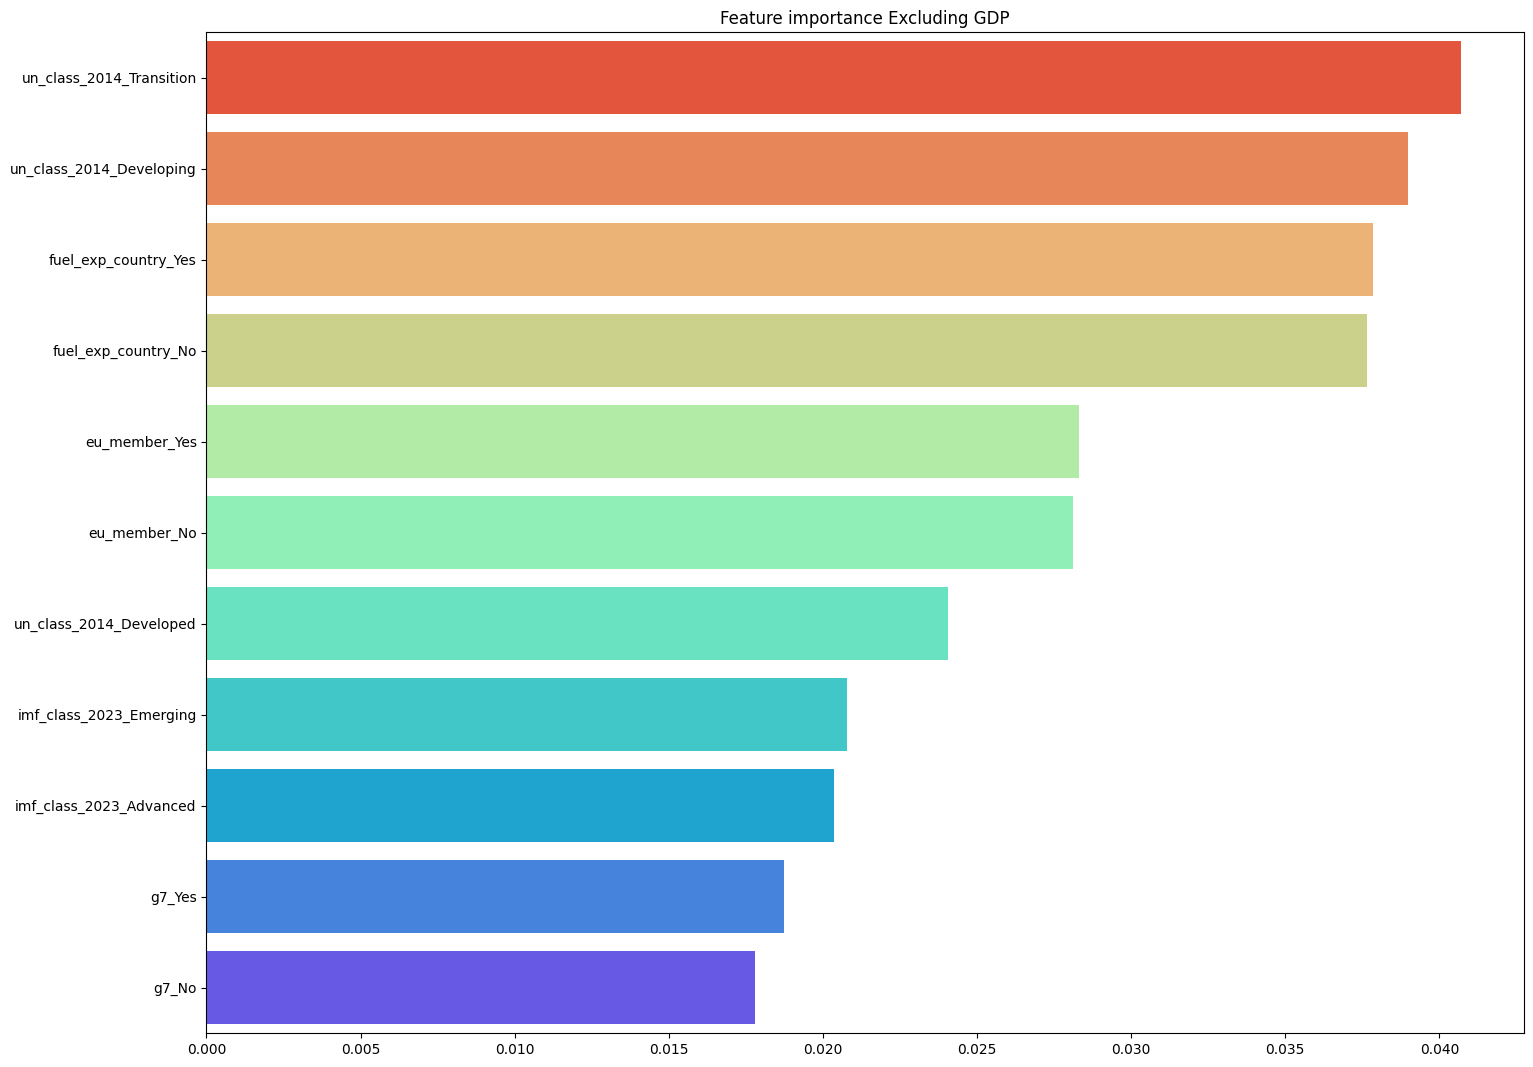

In [38]:
# Drop 'gdp_ppp_2022' and 'gdp_pc_2022' from the feature importances Series
fimp_nogdp = fimp.drop(['gdp_ppp_2022', 'gdp_pc_2022'])

# Plot feature importances
plt.figure(figsize=(17,13))
plt.title("Feature importance Excluding GDP")
ax = sns.barplot(y=fimp_nogdp.index, x=fimp_nogdp.values, palette='rainbow_r', orient='h')
plt.show()

## 3.3 Conclusion

Ignoring GDP features - which are obviously highly correlated to wealth rank - let's summarize what our Random Forest model has learned:

* un class - specifically countries in transition or developing - is moderately correlated to wealth rank
* fuel exportation is an important feature in determining wealth rank
* membership in the european union is moderately correlated with wealth rank
* imf class has a small effect on wealth rank
* membership in the G7 has little effect on wealth rank